In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Electromagnetic Screen

### Single Sample

In [28]:
EMData = np.load("../data/EMData-20230116.npy")

In [52]:
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.50)
CLUSTER_TAGS = [-1]

def coord_test(x, y):
    if x < 0 or y < 0 or x >= 25 or y >= 30:
        return False
    else:
        True

def check_nearby_ids(mat, x, y):
    dirlt = [-1,0,1]
    for dy in dirlt:
        for dx in dirlt:
            if mat[x-dx][y-dy] < -1:
                return mat[x-dx][y-dy]

    return -1

def cluster_tagging(segmented_image, x, y):
    dirlt = [-1,0,1]
    if coord_test(x, y) == False:
        return segmented_image

    # any positive pixel untouched through implementation stays +ive
    if segmented_image[x][y] in [0, 254]:
        if segmented_image[x][y] == 254:
            # setting cluster id to background
            segmented_image[x][y] = -1
            # print(segmented_image[x][y])
            for dy in dirlt:
                for dx in dirlt:
                    if dx+dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
        
        else:
            adj_id = check_nearby_ids(segmented_image, x, y)
            if adj_id!=-1:
                cluster_id = adj_id
            else: 
                cluster_id = CLUSTER_TAGS[-1] - 1
                CLUSTER_TAGS.append(cluster_id)
                
            segmented_image[x][y] = cluster_id
            for dy in dirlt:
                for dx in dirlt:
                    if dx == 0 and dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
    
    return segmented_image

def relabel(labels):
    # max number of labels belong to background/noise region
    bglabel = Counter(labels.flatten()).most_common(1)[-1][0]
    signal_label = list(Counter(labels.flatten()))[-1]

    # relabeling the pixels
    for i in range(len(labels)):
        if labels[i] != bglabel:
            labels[i] = signal_label
    
    return labels

def cluster_detect(energy_snap, verbose=True):
    # kmeans from energy snap
    energy_snap = energy_snap/np.max(energy_snap)
    energy_snap = 1 - energy_snap
    energy_snap = np.array(energy_snap * 255, dtype = np.uint8)
    energy_snap = cv2.cvtColor(energy_snap, cv2.COLOR_GRAY2BGR)

    #if verbose:
    #    plt.imshow(energy_snap)

    et_vals_em = energy_snap.reshape((-1,1))
    et_vals_em = np.float32(et_vals_em)
 
    k = 5  #background vs signal portion
    _, labels, centers = cv2.kmeans(et_vals_em, k, None, CRITERIA, 30, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    labels = relabel(labels)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((energy_snap.shape))
    
    # reshuffling detected clusters from energy based to locality based
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    segmented_image[np.where(segmented_image == min(np.unique(segmented_image)))] = 0
    segmented_image[np.where(segmented_image == max(np.unique(segmented_image)))] = 254

    if verbose:
        plt.imshow(segmented_image)
        
    tagged_pixels = cluster_tagging(np.array(segmented_image, dtype=int), 0, 0)

    return tagged_pixels

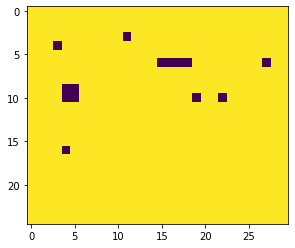

In [53]:
# EM Input Visual
sample_number = 0
energy_snap = EMData[sample_number, 0, :, :]
segmented_image = cluster_detect(energy_snap, verbose=True)

In [54]:
np.unique(segmented_image)

array([-9, -8, -7, -6, -5, -4, -3, -2, -1])

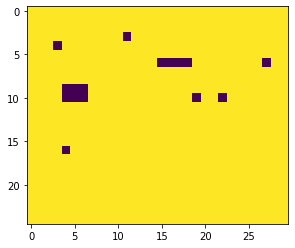

In [55]:
mc_truth = EMData[sample_number, 1, :, :]
mc_out = np.copy(mc_truth)
mc_out[np.where(mc_out==-1)] = mc_out.max() + 1
mc_out = 1-mc_out
mc_out = np.array(mc_out * 255, dtype = np.uint8)
#mc_out = cv2.cvtColor(mc_out, cv2.COLOR_GRAY2BGR)

plt.imshow(mc_out)

#### Testing pipeline

1. Map the new labels to MC truth labels
2. Loop over Detected and MC Clusters
3. **Match Condition:**
    - |neta_algo - neta_mc|  <  threshold  &&  |phi_algo - phi_mc|  <  Threshold
4. **Testing Points per loop:**
    - (E_algo - E_MC) / E_MC
    - Found in MC and not in Detected (False Negative)
    - Found in Detected and not in MC (False Positive)

In [47]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image

In [48]:
np.unique(segmented_image), np.unique(mc_truth)

(array([-6, -5, -4, -3, -2, -1]), array([-1.,  0.,  1.,  2.]))

In [49]:
predicted = mc_label_convert(segmented_image, mc_truth)

In [50]:
np.unique(predicted), np.unique(mc_truth)

(array([-1,  0,  2]), array([-1.,  0.,  1.,  2.]))

In [21]:
def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [ ]:
# Reconstruction Energy
thresh = 4
y_pred = []
energy_dist = []
for label in np.unique(mc_truth):
    if label == 0.0:
        continue

    matched, rel_energy = False, -1
    ROI_mc = np.where(mc_truth==label)
    ROI_algo = np.where(predicted==label)

    E_mc = np.sum(energy_snap[ROI_mc])
    E_algo = np.sum(energy_snap[ROI_algo])

    if len(ROI_algo) == 0:
        matched = (False, "False Negative")

    if len(ROI_mc) == 0 and len(ROI_algo) !=0:
        matched = (False, "False Positive")

    eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

    if eta_res < thresh and phi_res < thresh:
        matched = True
        rel_energy = abs(E_algo - E_mc)/E_mc
    else:
        matched = (False, "Very Low Overlap")
        rel_energy = 1 # E_algo == 0
    
    # collecting testing data
    y_pred.append(matched)
    if rel_energy >= 0: energy_dist.append(rel_energy)

ValueError: max() arg is an empty sequence

In [254]:
y_pred, energy_dist

([True, False, False, False], [0.0, 1, 1, 1])

In [ ]:
# different types particles (2), therefore 2 types plot 
# add entries for mismatched

### Complete Run

In [33]:
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.50)
CLUSTER_TAGS = [-1]

def coord_test(x, y):
    if x < 0 or y < 0 or x >= 25 or y >= 30:
        return False
    else:
        True

def check_nearby_ids(mat, x, y):
    dirlt = [-1,0,1]
    for dy in dirlt:
        for dx in dirlt:
            if mat[x-dx][y-dy] < -1:
                return mat[x-dx][y-dy]

    return -1

def cluster_tagging(segmented_image, x, y):
    dirlt = [-1,0,1]
    if coord_test(x, y) == False:
        return segmented_image

    # any positive pixel untouched through implementation stays +ive
    if segmented_image[x][y] in [0, 254]:
        if segmented_image[x][y] == 254:
            # setting cluster id to background
            segmented_image[x][y] = -1
            # print(segmented_image[x][y])
            for dy in dirlt:
                for dx in dirlt:
                    if dx+dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
        
        else:
            adj_id = check_nearby_ids(segmented_image, x, y)
            if adj_id!=-1:
                cluster_id = adj_id
            else: 
                cluster_id = CLUSTER_TAGS[-1] - 1
                CLUSTER_TAGS.append(cluster_id)
                
            segmented_image[x][y] = cluster_id
            for dy in dirlt:
                for dx in dirlt:
                    if dx == 0 and dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
    
    return segmented_image

def relabel(labels):
    # max number of labels belong to background/noise region
    bglabel = Counter(labels.flatten()).most_common(1)[-1][0]
    signal_label = list(Counter(labels.flatten()))[-1]

    # relabeling the pixels
    for i in range(len(labels)):
        if labels[i] != bglabel:
            labels[i] = signal_label
    
    return labels

def cluster_detect(energy_snap, verbose=True):
    # kmeans from energy snap
    energy_snap = energy_snap/np.max(energy_snap)
    energy_snap = 1 - energy_snap
    energy_snap = np.array(energy_snap * 255, dtype = np.uint8)
    energy_snap = cv2.cvtColor(energy_snap, cv2.COLOR_GRAY2BGR)

    #if verbose:
    #    plt.imshow(energy_snap)

    et_vals_em = energy_snap.reshape((-1,1))
    et_vals_em = np.float32(et_vals_em)
 
    k = 5  #background vs signal portion
    _, labels, centers = cv2.kmeans(et_vals_em, k, None, CRITERIA, 30, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    labels = relabel(labels)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((energy_snap.shape))
    
    # reshuffling detected clusters from energy based to locality based
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    segmented_image[np.where(segmented_image == min(np.unique(segmented_image)))] = 0
    segmented_image[np.where(segmented_image == max(np.unique(segmented_image)))] = 254

    if verbose:
        plt.imshow(segmented_image)
        
    tagged_pixels = cluster_tagging(np.array(segmented_image, dtype=int), 0, 0)

    return tagged_pixels
    
def test(predicted, mc_truth):
    thresh = 3
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1 #TODO: Check value??

        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1 #TODO: Check value??

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1 # E_algo == 0

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

In [34]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image

In [35]:
def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [36]:
EMData = np.load("../data/EMData-20230120.npy")

In [37]:
EMData.shape

(10000, 2, 25, 30)

In [38]:
all_matched, all_rel_energy, sn = [], [], 0
for i in range(EMData.shape[0]):
    CLUSTER_TAGS = [-1]
    energy_snap = EMData[i, 0, :, :]
    try:
        segmented_image = cluster_detect(energy_snap, verbose=False)
        mc_truth = EMData[i, 1, :, :]
        predicted = mc_label_convert(segmented_image, mc_truth)
        matched, rel_energy = test(predicted, mc_truth)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
    except:
        #TODO: resolve edge cases, sample 6, 
        pass

Text(0.5, 0, 'normalized energy difference')

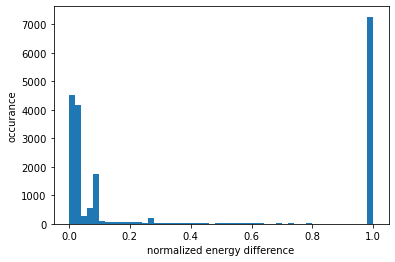

In [47]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

Text(0.5, 0, 'normalized energy difference')

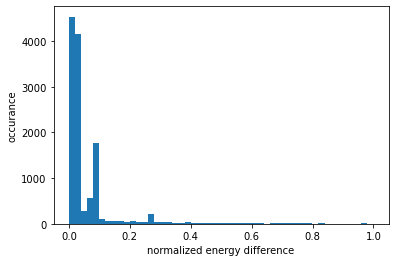

In [46]:
sub_rel = [i for i in all_rel_energy if i<1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

Text(0.5, 0, 'normalized energy difference')

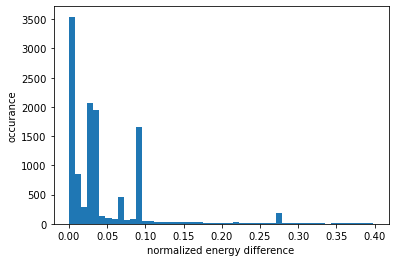

In [58]:
sub_rel = [i for i in all_rel_energy if (i<0.4)]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [ ]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image

In [42]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched: ", len(all_matched) - matches)

Correct Matches:  12660
Incorrect Matched:  7269


In [43]:
len(all_matched)

19929

In [44]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [45]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='False Negative'])
print("False Negative: ", fneg)

fposi = len([x for x in unmatched if x=='False Positive'])
print("False Positive: ", fposi)

Threshold Mismatch:  6109
False Negative:  1160
False Positive:  0


In [ ]:
# issues: 
# 1. Edge Cases
# 2. Thresholding Strategy
# 3. E_algo > E_MC?? How?? That happens when clusters are detected as joint due to overlap (We have 3 of such cases)

In [ ]:
# results:
# 1. Plots (energy difference)

In [32]:
sn

5737